# Used Car sales data set

Source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 

### Purpose of predictive model
This application will provide you with an amount that you can expect to sell for your car for on Craiglist. 

Disclaimer: this tool is only intended as a guide to help you decide your car sale price. What you decide to ask for is entirely up to you. Remember: your car is only worth what someone else is prepared to pay for it ;-)     

Craig list car sales: https://sfbay.craigslist.org/search/cta

Consider following feature: 
* how much do you want to sell your car for 
* is it a good or bad deal? 

include a custom search link: https://sfbay.craigslist.org/search/cta?query=mustang+gt+convertible

This iteration of the analysis compares various regression models to find the best fit

In [1]:
import pandas as pd
import numpy as np
# from math import sqrt

# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import os

# import plotly as py 
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlib as mpl
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)


In [2]:
# make this notebook's output stable across runs
np.random.seed(30)

In [3]:
DATA_FILE = "s:/Data/used_car_sales/vehicles.csv"

# only load columns for regression model
# exclude high cardinality columns - such as model 
# except for id, the other ones will be considered for regression  modeling

USE_COLUMNS = [
    'id',
#     'url',
#     'region',
#     'region_url',
    'price',
    'year',
    'manufacturer',
   'model',
    'condition',
    'cylinders',
    'fuel',
    'odometer',
#    'title_status',
    'transmission',
#     'VIN',
   'drive',
    'size',
    'type',
#    'paint_color',
#     'image_url',
#     'description',
#     'county',
    'state',
#     'lat',
#     'long'
#    'posting_date'
]

COL_DATA_TYPES = {
     'id': object,
#     'url',
#     'region',
#     'region_url',
    'price': float,
    'year': float,
#     'manufacturer',
#     'model',
#     'condition',
#     'cylinders',
#     'fuel',
    'odometer': float,
#     'title_status',
#     'transmission',
#     'VIN',
#     'drive',
#     'size',
#     'type',
#     'paint_color',
#     'image_url',
#     'description',
#     'county',
#     'state',
    'lat': float,
    'long': float
#     'posting_date'
}

In [4]:
df = pd.read_csv(DATA_FILE, usecols = USE_COLUMNS, dtype=COL_DATA_TYPES)

In [28]:
# exclude records with null year, manufaturer, type and price   
df = df.dropna(subset=['year','manufacturer','odometer','type','price'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293744 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            293744 non-null  object  
 1   price         293744 non-null  float64 
 2   year          293744 non-null  int16   
 3   manufacturer  293744 non-null  category
 4   model         291322 non-null  object  
 5   condition     200548 non-null  category
 6   cylinders     197425 non-null  category
 7   fuel          292101 non-null  category
 8   odometer      293744 non-null  float64 
 9   transmission  292339 non-null  category
 10  drive         232028 non-null  category
 11  size          100554 non-null  category
 12  type          293744 non-null  category
 13  state         293744 non-null  category
 14  classic_car   293744 non-null  int64   
 15  modern_car    293744 non-null  int64   
 16  antique_car   293744 non-null  int64   
dtypes: category(9), float64(2), 

In [30]:
df.nunique()

id              293744
price            13267
year               104
manufacturer        42
model            19435
                 ...  
type                13
state               51
classic_car          2
modern_car           2
antique_car          2
Length: 17, dtype: int64

In [31]:
pd.set_option('display.max_rows', None)

In [32]:
df['fuel'].unique()

['gas', 'other_fuel', 'diesel', 'hybrid', NaN, 'electric']
Categories (5, object): ['diesel', 'electric', 'gas', 'hybrid', 'other_fuel']

<AxesSubplot:xlabel='fuel'>

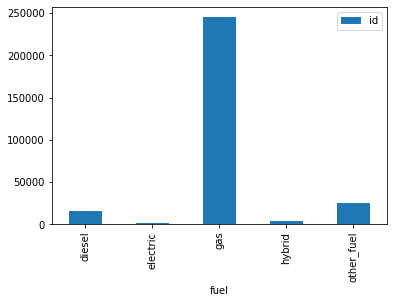

In [33]:
df[['fuel','id']].groupby('fuel').count().plot(kind='bar')

In [34]:
df['transmission'].unique()

['other_transmission', 'automatic', 'manual', NaN]
Categories (3, object): ['automatic', 'manual', 'other_transmission']

<AxesSubplot:xlabel='transmission'>

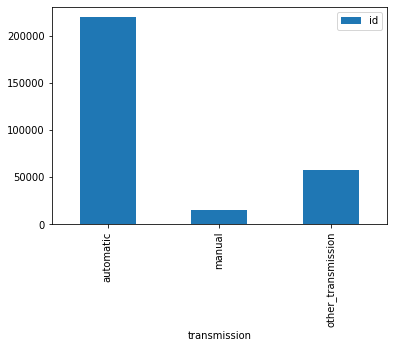

In [35]:
df[['transmission','id']].groupby('transmission').count().plot(kind='bar')

In [36]:
df['drive'].unique()

[NaN, 'rwd', '4wd', 'fwd']
Categories (3, object): ['4wd', 'fwd', 'rwd']

<AxesSubplot:xlabel='drive'>

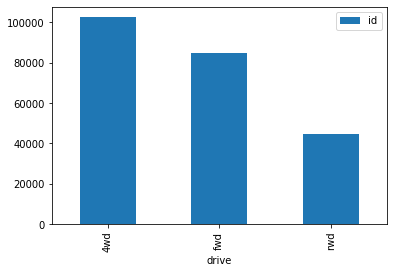

In [37]:
df[['drive','id']].groupby('drive').count().plot(kind='bar')

In [38]:
df['type'].unique()

['pickup', 'truck', 'other_type', 'coupe', 'SUV', ..., 'offroad', 'convertible', 'wagon', 'van', 'bus']
Length: 13
Categories (13, object): ['SUV', 'bus', 'convertible', 'coupe', ..., 'sedan', 'truck', 'van', 'wagon']

<AxesSubplot:xlabel='type'>

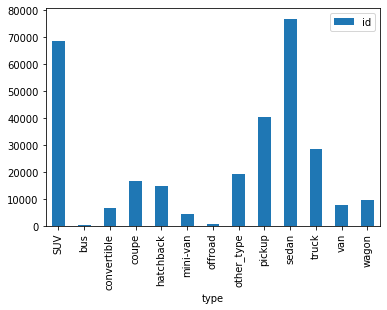

In [39]:
df[['type','id']].groupby('type').count().plot(kind='bar')

In [40]:
# update value 'other' to more specific value
df.loc[df[(df['fuel'] == 'other')].index,'fuel'] = 'other_fuel'
df.loc[df[(df['transmission'] == 'other')].index,'transmission'] = 'other_transmission'
df.loc[df[(df['type'] == 'other')].index,'type'] = 'other_type'

In [41]:
pd.set_option('display.max_rows', 15)

In [42]:
# convert to category columns - memory optimization

df['year'] = df['year'].astype('int16')
df['manufacturer'] = df['manufacturer'].astype('category')
df['condition'] = df['condition'].astype('category')
df['cylinders'] = df['cylinders'].astype('category')
df['fuel'] = df['fuel'].astype('category')
df['transmission'] = df['transmission'].astype('category')
df['drive'] = df['drive'].astype('category')
df['size'] = df['size'].astype('category')
df['type'] = df['type'].astype('category')
df['state'] = df['state'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293744 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            293744 non-null  object  
 1   price         293744 non-null  float64 
 2   year          293744 non-null  int16   
 3   manufacturer  293744 non-null  category
 4   model         291322 non-null  object  
 5   condition     200548 non-null  category
 6   cylinders     197425 non-null  category
 7   fuel          292101 non-null  category
 8   odometer      293744 non-null  float64 
 9   transmission  292339 non-null  category
 10  drive         232028 non-null  category
 11  size          100554 non-null  category
 12  type          293744 non-null  category
 13  state         293744 non-null  category
 14  classic_car   293744 non-null  int64   
 15  modern_car    293744 non-null  int64   
 16  antique_car   293744 non-null  int64   
dtypes: category(9), float64(2), 

C:\Users\dgouin\AppData\Local\Temp\ipykernel_17304\827515111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype('int16')
C:\Users\dgouin\AppData\Local\Temp\ipykernel_17304\827515111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manufacturer'] = df['manufacturer'].astype('category')
C:\Users\dgouin\AppData\Local\Temp\ipykernel_17304\827515111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

### regression model notes
* price is going to be our target variable 
* odometer reading will be broken down into bins 

In [43]:
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('^display.', silent=True)

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,293744.00,19739.10,14239.52,100.00,8228.00,16988.00,28590.00,100000.00
year,293744.00,2012.02,8.21,1900.00,2009.00,2014.00,2017.00,2022.00
odometer,293744.00,90605.27,148143.81,0.00,34484.75,80731.50,129179.00,10000000.00
classic_car,293744.00,0.01,0.11,0.00,0.00,0.00,0.00,1.00
modern_car,293744.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
antique_car,293744.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00


In [45]:
# use clip function to drop price below 100 and above 100000  
df = df[(df['price'] >= 100) & (df['price'] <= 100000)]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,293744.00,19739.10,14239.52,100.00,8228.00,16988.00,28590.00,100000.00
year,293744.00,2012.02,8.21,1900.00,2009.00,2014.00,2017.00,2022.00
odometer,293744.00,90605.27,148143.81,0.00,34484.75,80731.50,129179.00,10000000.00
classic_car,293744.00,0.01,0.11,0.00,0.00,0.00,0.00,1.00
modern_car,293744.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
antique_car,293744.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00


<AxesSubplot:xlabel='year', ylabel='price'>

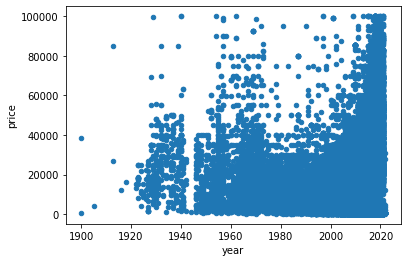

In [46]:
#scatter plot of price vs. year 
df.plot(kind="scatter", x="year", y="price")

There seems to be a trend where car price goes down for older cars, up to a point where it starts going up again - for instance, for cars older than 1980 (classic cars). And then the price trend goes down again for antique cars - i.e. prior to 1925. We will take this into account in the regression model by creating a car_categories of: `['modern','classic','antique']` 

These will appear as features in the regression model, so in preparation for that, we will create a matrix for these categories in the existing dataframe. 

In [47]:
# would catagorizing cars as classic if built prior to 1980, 
# increase the accuracy of our model? 
df['classic_car'] = 0 
df.loc[df[(df['year'] < 1980) & (df['year'] > 1925)].index,'classic_car'] = 1

df['modern_car'] = 0 
df.loc[df[(df['year'] >= 1980)].index,'modern_car'] = 1

df['antique_car'] = 0 
df.loc[df[(df['year'] <= 1925)].index,'antique_car'] = 1

In [48]:
df[(df['year'] < 1985) & (df['year'] > 1975)].sample(20)

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,state,classic_car,modern_car,antique_car
335028,7308494154,22000.00,1979,pontiac,firebird trans am,excellent,8 cylinders,gas,72000.00,automatic,rwd,mid-size,coupe,pa,1,0,0
410127,7313633230,5850.00,1984,pontiac,sunbird,excellent,4 cylinders,gas,131000.00,automatic,fwd,mid-size,convertible,wa,0,1,0
80598,7302898963,6700.00,1980,jeep,cj5,good,6 cylinders,gas,174600.00,manual,4wd,NaN,convertible,co,0,1,0
343040,7308774745,7000.00,1982,mercedes-benz,NaN,excellent,6 cylinders,gas,116000.00,automatic,rwd,NaN,convertible,ri,0,1,0
406661,7307537260,12000.00,1982,mercedes-benz,300d,excellent,5 cylinders,diesel,137000.00,automatic,rwd,compact,sedan,wa,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37653,7313161763,6500.00,1981,toyota,trekker,fair,4 cylinders,gas,100000.00,manual,4wd,NaN,pickup,ca,0,1,0
262689,7302397183,6800.00,1983,jeep,wagoneer,fair,8 cylinders,gas,132000.00,automatic,4wd,full-size,SUV,nm,0,1,0
258505,7305575010,17000.00,1983,lincoln,mark vi,good,NaN,gas,34000.00,automatic,NaN,NaN,sedan,nj,0,1,0
284879,7312786450,7500.00,1983,jeep,cj-7,good,6 cylinders,gas,156000.00,automatic,4wd,mid-size,SUV,nh,0,1,0


In [26]:
# Check "correlations"
corrs = df.corr()
corrs['price'].sort_values()

odometer      -0.24
classic_car   -0.01
antique_car   -0.00
modern_car     0.01
year           0.41
price          1.00
Name: price, dtype: float64

car type is apparently not so much a factor

In [49]:
df['odometer'].isna().sum()

0

In [50]:
df[df['odometer'] <= 10]['odometer'].count()

2157

In [51]:
# odo is required, drop odo of 10 miles or less
df = df[df['odometer'] > 10]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,291587.00,19782.79,14201.23,100.00,8450.00,16990.00,28590.00,100000.00
year,291587.00,2012.05,8.07,1900.00,2009.00,2014.00,2017.00,2022.00
odometer,291587.00,91275.50,148484.89,11.00,35200.00,81481.00,129701.00,10000000.00
classic_car,291587.00,0.01,0.11,0.00,0.00,0.00,0.00,1.00
modern_car,291587.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
antique_car,291587.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00


In [55]:
# create bins for odometer
df['odometer_cat'] = pd.cut(df["odometer"], 
                  bins=[0, 10000, 25000, 50000, 80000, 100000, 150000, 200000, 250000, 500000, 750000, np.inf], 
                  labels=['  0-010k',' 10k-25k',' 25k-50k',' 50k-80k',' 80k-100k','100k-150k','150k-200k',
                              '200k-250k','250k-500k','500k-750k','750k+'])

df['odometer_cat'] = df['odometer_cat'].astype('category')

df['odometer_cat'].describe().T

count        291587
unique           11
top       100k-150k
freq          67291
Name: odometer_cat, dtype: object

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291587 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            291587 non-null  object  
 1   price         291587 non-null  float64 
 2   year          291587 non-null  int16   
 3   manufacturer  291587 non-null  category
 4   model         289212 non-null  object  
 5   condition     199425 non-null  category
 6   cylinders     196038 non-null  category
 7   fuel          289954 non-null  category
 8   odometer      291587 non-null  float64 
 9   transmission  290231 non-null  category
 10  drive         230498 non-null  category
 11  size          100086 non-null  category
 12  type          291587 non-null  category
 13  state         291587 non-null  category
 14  classic_car   291587 non-null  int64   
 15  modern_car    291587 non-null  int64   
 16  antique_car   291587 non-null  int64   
 17  odometer_cat  291587 non-nul

### Fill in the data gaps
1. `model` missing for some records. However, there are over 20k different model descriptions. It is so granular, it should probably be examine further to categorize in fewer categories? For now, will rely only on manufacturer for initial iteration of the regression
1. condition will default to `good` 
1. cylinders will ignore for now and exclude from the regression model 
1. fuel - will default to `gas` 
1. transmission will default to `automatic` 
1. size has a lot of missing records... will ignore and only rely on type 

In [58]:
# condition 
df['condition'].fillna('excellent', inplace=True)
df['condition'].unique()


['good', 'excellent', 'fair', 'like new', 'new', 'salvage']
Categories (6, object): ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']

<AxesSubplot:xlabel='condition'>

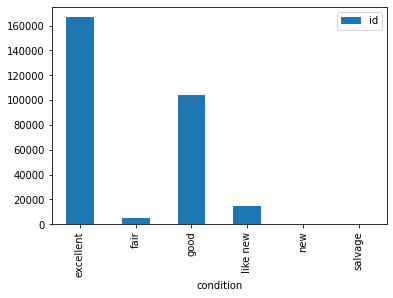

In [59]:
df[['condition','id']].groupby('condition').count().plot(kind='bar')

In [60]:
# fuel
df['fuel'].fillna('gas', inplace=True)
df['fuel'].unique()


['gas', 'other_fuel', 'diesel', 'hybrid', 'electric']
Categories (5, object): ['diesel', 'electric', 'gas', 'hybrid', 'other_fuel']

<AxesSubplot:xlabel='fuel'>

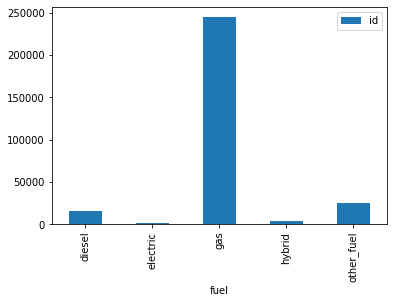

In [61]:
df[['fuel','id']].groupby('fuel').count().plot(kind='bar')

In [62]:
# transmission
df['transmission'].fillna('automatic', inplace=True)
df['transmission'].unique()


['other_transmission', 'automatic', 'manual']
Categories (3, object): ['automatic', 'manual', 'other_transmission']

<AxesSubplot:xlabel='transmission'>

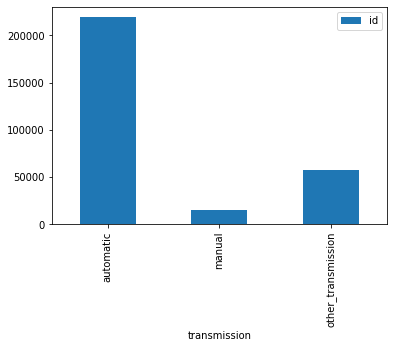

In [63]:
df[['transmission','id']].groupby('transmission').count().plot(kind='bar')

In [64]:
# drive
df['drive'].fillna('fwd', inplace=True)
df['drive'].unique()

['fwd', 'rwd', '4wd']
Categories (3, object): ['4wd', 'fwd', 'rwd']

<AxesSubplot:xlabel='drive'>

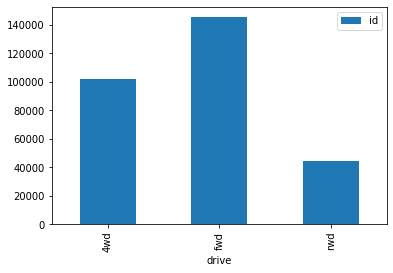

In [65]:
df[['drive','id']].groupby('drive').count().plot(kind='bar')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291587 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            291587 non-null  object  
 1   price         291587 non-null  float64 
 2   year          291587 non-null  int16   
 3   manufacturer  291587 non-null  category
 4   model         289212 non-null  object  
 5   condition     291587 non-null  category
 6   cylinders     196038 non-null  category
 7   fuel          291587 non-null  category
 8   odometer      291587 non-null  float64 
 9   transmission  291587 non-null  category
 10  drive         291587 non-null  category
 11  size          100086 non-null  category
 12  type          291587 non-null  category
 13  state         291587 non-null  category
 14  classic_car   291587 non-null  int64   
 15  modern_car    291587 non-null  int64   
 16  antique_car   291587 non-null  int64   
 17  odometer_cat  291587 non-nul

### Setup data for regression modeling 

In [74]:
# create model for state of california
df_model = df[df['state'] == 'ca'][['price',
              'year',
             'manufacturer',
              'condition',
              'fuel',
              'odometer_cat',
              'transmission',
              'drive',
              'type',
#               'state',
              'classic_car',
              'modern_car',
              'antique_car']]

In [75]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price         33956 non-null  float64 
 1   year          33956 non-null  int16   
 2   manufacturer  33956 non-null  category
 3   condition     33956 non-null  category
 4   fuel          33956 non-null  category
 5   odometer_cat  33956 non-null  category
 6   transmission  33956 non-null  category
 7   drive         33956 non-null  category
 8   type          33956 non-null  category
 9   classic_car   33956 non-null  int64   
 10  modern_car    33956 non-null  int64   
 11  antique_car   33956 non-null  int64   
dtypes: category(7), float64(1), int16(1), int64(3)
memory usage: 1.6 MB


In [76]:
df_model = pd.get_dummies(df_model, columns = list(df_model.select_dtypes(include='category')), prefix='', prefix_sep='')

In [77]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 88 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               33956 non-null  float64
 1   year                33956 non-null  int16  
 2   classic_car         33956 non-null  int64  
 3   modern_car          33956 non-null  int64  
 4   antique_car         33956 non-null  int64  
 5   acura               33956 non-null  uint8  
 6   alfa-romeo          33956 non-null  uint8  
 7   aston-martin        33956 non-null  uint8  
 8   audi                33956 non-null  uint8  
 9   bmw                 33956 non-null  uint8  
 10  buick               33956 non-null  uint8  
 11  cadillac            33956 non-null  uint8  
 12  chevrolet           33956 non-null  uint8  
 13  chrysler            33956 non-null  uint8  
 14  datsun              33956 non-null  uint8  
 15  dodge               33956 non-null  uint8  
 16  

In [78]:
df_model.shape

(33956, 88)

In [79]:
df_model.sample(25)

,price,year,classic_car,modern_car,antique_car,acura,alfa-romeo,aston-martin,audi,bmw,...,coupe,hatchback,mini-van,offroad,other_type,pickup,sedan,truck,van,wagon
33106,5499.00,2012,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
61612,4500.00,2005,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56984,332.00,2019,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24989,30995.00,2014,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46692,11995.00,2014,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24074,19995.00,2020,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25469,19990.00,2019,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
57035,19990.00,2017,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
54076,11995.00,2013,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Check "correlations" again
corrs = df_model.corr()
corr_factors = corrs['price'].sort_values()

pd.set_option('display.max_rows', None)
print(corr_factors)
pd.set_option('display.max_rows', 10)


gas                  -0.28
100k-150k            -0.27
150k-200k            -0.24
fwd                  -0.23
automatic            -0.21
sedan                -0.21
200k-250k            -0.15
fair                 -0.14
honda                -0.10
excellent            -0.10
250k-500k            -0.09
hatchback            -0.09
nissan               -0.09
manual               -0.09
hyundai              -0.08
mini-van             -0.07
 80k-100k            -0.07
wagon                -0.06
volkswagen           -0.06
kia                  -0.05
toyota               -0.05
chrysler             -0.05
salvage              -0.05
mercury              -0.04
saturn               -0.04
SUV                  -0.04
subaru               -0.04
mazda                -0.04
dodge                -0.04
hybrid               -0.03
mitsubishi           -0.03
pontiac              -0.03
mini                 -0.03
modern_car           -0.02
fiat                 -0.02
750k+                -0.02
buick                -0.02
o

C:\Users\dgouin\AppData\Local\Temp\ipykernel_17304\1543825126.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(corrs[abs(corr_factors) >= .1]);


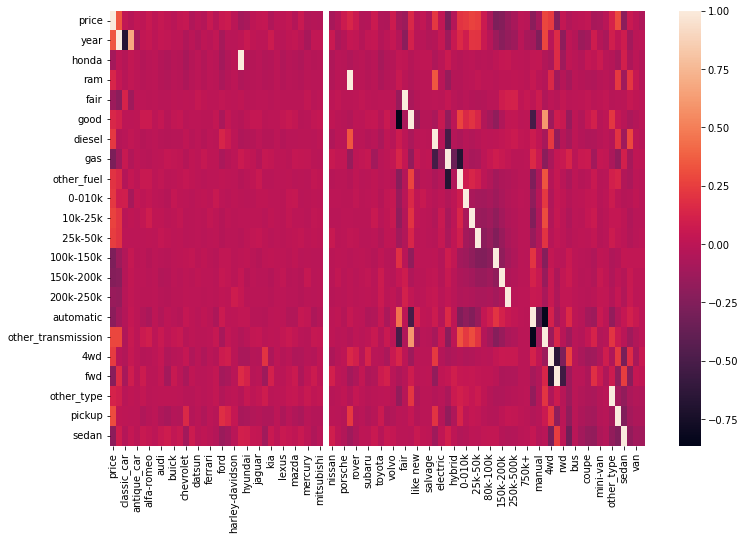

In [112]:
# heatmap correlations
plt.figure(figsize=(12,8))
sns.heatmap(corrs[abs(corr_factors) >= .1]);

In [109]:
# retain columns with correlation factors outside -.1 to .1 as features 
feature_list = corr_factors.loc[abs(corr_factors) >= .1].index.tolist()

feature_list

['gas',
 '100k-150k',
 '150k-200k',
 'fwd',
 'automatic',
 'sedan',
 '200k-250k',
 'fair',
 'honda',
 'other_type',
 'ram',
 'good',
 'other_fuel',
 '  0-010k',
 'diesel',
 '4wd',
 ' 25k-50k',
 ' 10k-25k',
 'other_transmission',
 'pickup',
 'year',
 'price']

In [113]:
# restrict to relevant features
df_model = df_model[feature_list].copy()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gas                 33956 non-null  uint8  
 1   100k-150k           33956 non-null  uint8  
 2   150k-200k           33956 non-null  uint8  
 3   fwd                 33956 non-null  uint8  
 4   automatic           33956 non-null  uint8  
 5   sedan               33956 non-null  uint8  
 6   200k-250k           33956 non-null  uint8  
 7   fair                33956 non-null  uint8  
 8   honda               33956 non-null  uint8  
 9   other_type          33956 non-null  uint8  
 10  ram                 33956 non-null  uint8  
 11  good                33956 non-null  uint8  
 12  other_fuel          33956 non-null  uint8  
 13    0-010k            33956 non-null  uint8  
 14  diesel              33956 non-null  uint8  
 15  4wd                 33956 non-null  uint8  
 16  

In [115]:
df_model.reset_index
df_model.head()

,gas,100k-150k,150k-200k,fwd,automatic,sedan,200k-250k,fair,honda,other_type,...,other_fuel,0-010k,diesel,4wd,25k-50k,10k-25k,other_transmission,pickup,year,price
21171,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,2018,16990.00
21174,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,2003,11975.00
21176,0,0,0,0,1,0,1,0,0,0,...,0,0,1,1,0,0,0,0,2003,21950.00
21178,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,2018,27590.00
21179,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,2018,21990.00


In [116]:
df_model.sample(15)

,gas,100k-150k,150k-200k,fwd,automatic,sedan,200k-250k,fair,honda,other_type,...,other_fuel,0-010k,diesel,4wd,25k-50k,10k-25k,other_transmission,pickup,year,price
48508,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,2003,3750.00
27215,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2011,16995.00
65794,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2018,37590.00
38829,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,2019,15888.00
27399,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2017,25777.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44305,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2016,8970.00
43862,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2018,57900.00
34386,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,2015,37590.00
21498,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,2017,24590.00


In [117]:
df_model.isna().sum().sum()

0

### Model Building

In [118]:
# declare target variable
y = df_model['price']
y.shape

(33956,)

In [119]:
X = df_model.drop(['price'], axis=1)
X.shape

(33956, 21)

In [120]:
list(X.columns)

['gas',
 '100k-150k',
 '150k-200k',
 'fwd',
 'automatic',
 'sedan',
 '200k-250k',
 'fair',
 'honda',
 'other_type',
 'ram',
 'good',
 'other_fuel',
 '  0-010k',
 'diesel',
 '4wd',
 ' 25k-50k',
 ' 10k-25k',
 'other_transmission',
 'pickup',
 'year']

In [122]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 30)

In [123]:
# Instantiate the SKlearn algorithm
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
mymodel = LinearRegression(fit_intercept=True, 
#                            normalize=False, # deprecated
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [125]:
# Fit the model to the training dataset
mymodel.fit(X_train, y_train)

LinearRegression()

### Examine resulting model

In [126]:
# what is the intercept? (the value when all predictors are zero)
mymodel.intercept_

-455904.52509993606

In [127]:
# what are the coefficients?
pd.options.display.float_format = '{:.5f}'.format
list(mymodel.coef_)

[1206.524841881094,
 -5328.567356322737,
 -8388.956257931755,
 -4604.431858123659,
 397.3097258338783,
 -2127.7428177918864,
 -10226.96459157207,
 -6567.205494203253,
 -391.8923468508713,
 4021.3628948208952,
 -167.42906033016746,
 -1052.4753701198345,
 4288.053058444601,
 12355.40614055657,
 11697.949756776563,
 2494.1128097533333,
 6462.403062965344,
 9520.23928664581,
 1336.1929534715086,
 7100.340355415625,
 235.67980620625846]

### App Prep

Some variables that will be needed to implement car sale price forecasting model

In [ ]:
# prediction model parameters - copy / paste from results above
intercept = -804538.8643260737

predictor_vars = ['year',
 'odometer',
 'ferrari',
 'gas',
 'diesel',
 'other_fuel',
 'sedan',
 'pickup',
 'other_type',
 'automatic',
 'other_transmission',
 'excellent',
 'good',
 'fair']

predictor_coeff = [390.5031441248841,
 -0.017659688952919708,
 103920.36002700841,
 1745.5726762019538,
 13946.538609987403,
 5743.117645250859,
 -4301.212153910639,
 8570.283187851448,
 3708.44941088399,
 -1170.7571963590008,
 3942.8207817679704,
 -2559.9572273672566,
 -3043.6496077529555,
 -9014.598056518584]

In [ ]:
predictor_model = {
    "intercept": intercept   
}

for v in range(0,len(predictor_vars)):
#     print(f"{predictor_vars[v]}: {predictor_coeff[v]}")
    predictor_model[predictor_vars[v]] = predictor_coeff[v]

print(predictor_model)

In [ ]:
CAR_MANUFACTURER = ['Acura', 'Alfa-Romeo', 'Aston-Martin', 'Audi', 'Bmw', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Datsun', 'Dodge', 'Ferrari',
       'Fiat', 'Ford', 'Gmc', 'Harley-Davidson', 'Honda', 'Hyundai',
       'Infiniti', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus',
       'Lincoln', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mini',
       'Mitsubishi', 'Morgan', 'Nissan', 'Pontiac', 'Porsche', 'Ram',
       'Rover', 'Saturn', 'Subaru', 'Tesla', 'Toyota', 'Volkswagen',
       'Volvo']

In [ ]:
FUEL_TYPE = ['gas',  'diesel', 'hybrid', 'electric', 'other']

In [ ]:
CAR_TYPE = ['pickup', 'truck', 'other_type', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'van', 'convertible', 'wagon',
       'bus']

In [ ]:
TRANSMISSION = ['automatic', 'manual', 'other']

In [ ]:
CAR_CONDITION = ['new', 'like new', 'excellent', 'good', 'fair',  'salvage']

#### App utils

In [ ]:
# create a dictionary of model intercept and coefficient values 
def initialize_predictor_model(intercept, predictor_vars):
    predictor_model = {'intercept': intercept}
    for v in range(0,len(predictor_vars) - 1):
        predictor_model[predictor_vars[v]] = predictor_coeff[v]
    return predictor_model

# reset user input 
def reset_model_input(predictor_vars):
    model_input = {'intercept': 1}
    for v in range(0,len(predictor_vars)):
        model_input[predictor_vars[v]] = 0 
    return model_input 

# generate prediction based on user input
def generate_prediction(predictor_model, model_input):
    prediction = 0
    for i in predictor_model.keys():
        prediction += predictor_model[i] * model_input[i]
    return '{:.2f}'.format(prediction)

In [ ]:
print(predictor_model.keys())

In [ ]:
predictor_vars = list(predictor_model.keys())
print(predictor_vars)

In [ ]:
model_input = reset_model_input(predictor_vars)

print(model_input)

In [ ]:
print(model_input['year'])

In [ ]:
model_input['year'] = 1980
model_input['ferrari'] = 1



In [ ]:
print(generate_prediction(predictor_model, model_input))

In [ ]:
REGRESSION_EQUATION = "Recommended Sale Price = " 
for v in predictor_model.keys():
    if v == "intercept":
        REGRESSION_EQUATION = REGRESSION_EQUATION + str(round(predictor_model[v],5)) + " + "
    else:
        REGRESSION_EQUATION = REGRESSION_EQUATION + "(" + str(round(predictor_model[v],5)) + " X " + v + ") + "
    
print(REGRESSION_EQUATION)

In [ ]:
special_message = ""
for i in predictor_model.keys():
    special_message = special_message + f"{predictor_model[i]}:  {model_input[i]} | "

print(predictor_model.keys())
print(special_message)

In [ ]:
for i in predictor_vars:
    print(i)

In [ ]:
for i in predictor_coeff:
    print(i)